In [ ]:
!nvidia-smi

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
from torch import nn
from collections import Counter
import plotly.express as px
from torch.optim import Adam

In [5]:
from google.colab import files
import zipfile

# Téléchargez le fichier zip depuis votre ordinateur local
uploaded = files.upload()

# Spécifiez le nom du fichier zip
Database_zip = list(uploaded.keys())[0]

# Extrayez le contenu du fichier zip dans le répertoire de destination
with zipfile.ZipFile(Database_zip, 'r') as zip_ref:
    zip_ref.extractall("Database")

Saving archive.zip to archive.zip


In [1]:
train_dataset_path ='C:/Users/MSI/OneDrive/Desktop/3 ING/Semestre 1/Indexation/Mini Projet/Travail Mini Projet/archive/train' 
valid_dataset_path = 'C:/Users/MSI/OneDrive/Desktop/3 ING/Semestre 1/Indexation/Mini Projet/Travail Mini Projet/archive/test'

In [7]:
import torch
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
pip install T


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement T (from versions: none)
ERROR: No matching distribution found for T

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import torchvision.transforms as T
# Data Augmentations
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor()
])

In [16]:
valid_augs = T.Compose([T.ToTensor()])

In [18]:
from torchvision.datasets import ImageFolder
# Load Datasets
trainset = ImageFolder(train_dataset_path, transform=train_augs)
validset = ImageFolder(valid_dataset_path, transform=valid_augs)

In [19]:
import plotly.express as px

def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

In [21]:
from collections import Counter
# Plot Class Distribution
labels = [label for _, label in trainset]
class_counts = Counter(labels)
plot_dist(class_counts, 'Trainset')

In [14]:
# Data Loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [23]:
class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()
        self.inception_net = timm.create_model('inception_v3', pretrained=True, num_classes=7)

    def forward(self, images, labels=None):
        if images.size(2) < 299 or images.size(3) < 299:
            images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=True)

        logits = self.inception_net(images)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss
        return logits


In [24]:
# Model, Optimizer, and Loss Function
inception_model = InceptionModel()
inception_model.to(DEVICE)
inception_optimizer = Adam(inception_model.parameters(), lr=LR)

In [25]:
# Training and Evaluation Functions
def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc="EPOCHS" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss': '%6f' % float(total_loss / (t + 1)), 'acc': '%6f' % float(total_acc / (t + 1))})
    return total_loss / len(dataloader), total_acc / len(dataloader)


In [26]:
def eval_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits, loss = model(images, labels)

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss': '%6f' % float(total_loss / (t + 1)), 'acc': '%6f' % float(total_acc / (t + 1))})
    return total_loss / len(dataloader), total_acc / len(dataloader)


In [29]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [30]:
import torch.nn.functional as F
# Training Loop
best_valid_losses = {'inception': np.inf}
inception_train_losses = []
inception_valid_losses = []
inception_train_accuracies = []
inception_valid_accuracies = []

for epoch in range(EPOCHS):
    inception_train_loss, inception_train_acc = train_fn(inception_model, trainloader, inception_optimizer, epoch)
    inception_eval_loss, inception_eval_acc = eval_fn(inception_model, validloader, epoch)

    inception_train_losses.append(inception_train_loss)
    inception_valid_losses.append(inception_eval_loss)
    inception_train_accuracies.append(inception_train_acc)
    inception_valid_accuracies.append(inception_eval_acc)

    # Print progress
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'Inception Train Loss: {inception_train_loss:.4f}, Train Acc: {inception_train_acc:.4f}, '
          f'Inception Valid Loss: {inception_eval_loss:.4f}, Valid Acc: {inception_eval_acc:.4f}')

    # Check for improvement in validation losses
    if inception_eval_loss < best_valid_losses['inception']:
        torch.save(inception_model.state_dict(), '/content/Inception.pt')
        print("Saved Best Inception Valid Loss")
        best_valid_losses['inception'] = inception_eval_loss

print(best_valid_losses['inception'])

EPOCH[VALID]1/20: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s, loss=1.458175, acc=0.520694]


Epoch [1/20], Inception Train Loss: 1.4799, Train Acc: 0.4285, Inception Valid Loss: 1.4582, Valid Acc: 0.5207
Saved Best Inception Valid Loss


EPOCH[VALID]2/20: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s, loss=1.224482, acc=0.550722]


Epoch [2/20], Inception Train Loss: 1.1910, Train Acc: 0.5524, Inception Valid Loss: 1.2245, Valid Acc: 0.5507
Saved Best Inception Valid Loss


EPOCH[VALID]3/20: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s, loss=1.053791, acc=0.602306]


Epoch [3/20], Inception Train Loss: 1.1061, Train Acc: 0.5802, Inception Valid Loss: 1.0538, Valid Acc: 0.6023
Saved Best Inception Valid Loss


EPOCH[VALID]4/20: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s, loss=1.057051, acc=0.604722]


Epoch [4/20], Inception Train Loss: 1.0590, Train Acc: 0.6005, Inception Valid Loss: 1.0571, Valid Acc: 0.6047


EPOCH[VALID]5/20: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s, loss=0.984613, acc=0.636361]


Epoch [5/20], Inception Train Loss: 1.0146, Train Acc: 0.6182, Inception Valid Loss: 0.9846, Valid Acc: 0.6364
Saved Best Inception Valid Loss


EPOCH[VALID]6/20: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s, loss=1.030627, acc=0.612389]


Epoch [6/20], Inception Train Loss: 0.9831, Train Acc: 0.6281, Inception Valid Loss: 1.0306, Valid Acc: 0.6124


EPOCH[VALID]7/20: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s, loss=0.955415, acc=0.633861]


Epoch [7/20], Inception Train Loss: 0.9530, Train Acc: 0.6379, Inception Valid Loss: 0.9554, Valid Acc: 0.6339
Saved Best Inception Valid Loss


EPOCH[VALID]8/20: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s, loss=0.978359, acc=0.646250]


Epoch [8/20], Inception Train Loss: 0.9177, Train Acc: 0.6534, Inception Valid Loss: 0.9784, Valid Acc: 0.6463


EPOCH[VALID]9/20: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s, loss=0.979585, acc=0.647361]


Epoch [9/20], Inception Train Loss: 0.9003, Train Acc: 0.6608, Inception Valid Loss: 0.9796, Valid Acc: 0.6474


EPOCH[VALID]10/20: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s, loss=0.917668, acc=0.665972]


Epoch [10/20], Inception Train Loss: 0.8735, Train Acc: 0.6742, Inception Valid Loss: 0.9177, Valid Acc: 0.6660
Saved Best Inception Valid Loss


EPOCH[VALID]11/20: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s, loss=0.920539, acc=0.664667]


Epoch [11/20], Inception Train Loss: 0.8392, Train Acc: 0.6883, Inception Valid Loss: 0.9205, Valid Acc: 0.6647


EPOCH[VALID]12/20: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s, loss=0.896320, acc=0.673000]


Epoch [12/20], Inception Train Loss: 0.8136, Train Acc: 0.6962, Inception Valid Loss: 0.8963, Valid Acc: 0.6730
Saved Best Inception Valid Loss


EPOCH[VALID]13/20: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s, loss=0.895919, acc=0.673611]


Epoch [13/20], Inception Train Loss: 0.7850, Train Acc: 0.7074, Inception Valid Loss: 0.8959, Valid Acc: 0.6736
Saved Best Inception Valid Loss


EPOCH[VALID]14/20: 100%|██████████| 225/225 [00:30<00:00,  7.50it/s, loss=0.927719, acc=0.677583]


Epoch [14/20], Inception Train Loss: 0.7607, Train Acc: 0.7180, Inception Valid Loss: 0.9277, Valid Acc: 0.6776


EPOCH[VALID]15/20: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s, loss=0.941876, acc=0.669000]


Epoch [15/20], Inception Train Loss: 0.7250, Train Acc: 0.7297, Inception Valid Loss: 0.9419, Valid Acc: 0.6690


EPOCH[VALID]16/20: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s, loss=0.896717, acc=0.682778]


Epoch [16/20], Inception Train Loss: 0.7002, Train Acc: 0.7350, Inception Valid Loss: 0.8967, Valid Acc: 0.6828


EPOCH[VALID]17/20: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s, loss=0.967372, acc=0.673000]


Epoch [17/20], Inception Train Loss: 0.6666, Train Acc: 0.7537, Inception Valid Loss: 0.9674, Valid Acc: 0.6730


EPOCH[VALID]18/20: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s, loss=0.967594, acc=0.664278]


Epoch [18/20], Inception Train Loss: 0.6401, Train Acc: 0.7634, Inception Valid Loss: 0.9676, Valid Acc: 0.6643


EPOCH[VALID]19/20: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s, loss=0.996319, acc=0.673722]


Epoch [19/20], Inception Train Loss: 0.6160, Train Acc: 0.7740, Inception Valid Loss: 0.9963, Valid Acc: 0.6737


EPOCH[VALID]20/20: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s, loss=0.982886, acc=0.687194]

Epoch [20/20], Inception Train Loss: 0.5845, Train Acc: 0.7816, Inception Valid Loss: 0.9829, Valid Acc: 0.6872
0.8959187549352646


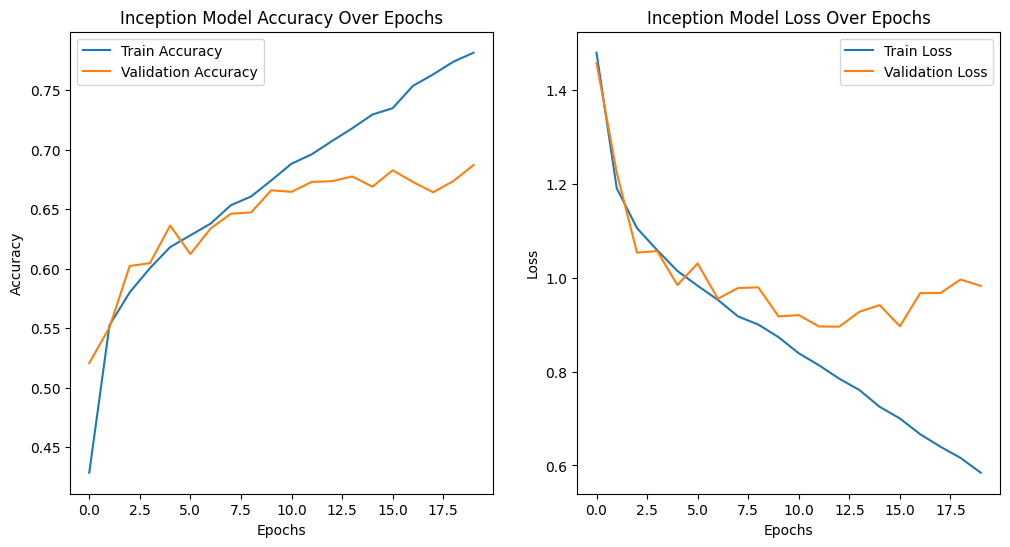

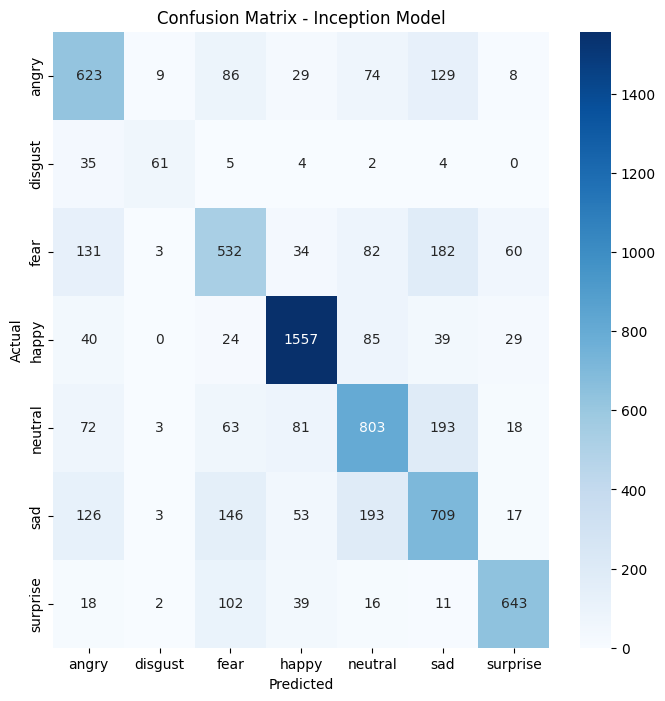

Overall Accuracy: 68.65%


In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Plotting accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(inception_train_accuracies, label='Train Accuracy')
plt.plot(inception_valid_accuracies, label='Validation Accuracy')
plt.title('Inception Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(inception_train_losses, label='Train Loss')
plt.plot(inception_valid_losses, label='Validation Loss')
plt.title('Inception Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Create a confusion matrix
inception_model.eval()
all_preds = []
all_labels = []

for images, labels in validloader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits = inception_model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Inception Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')